In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from grating import *
from ext_signal import *

In [3]:
np.matmul(sRGB2LMS[0,:], sRGB2LMS[1,:].T)

0.5375346139129525

In [4]:
sRGB2LMS

array([[0.3139188 , 0.63955568, 0.0465325 ],
       [0.15529867, 0.75794512, 0.08672079],
       [0.01772126, 0.10944944, 0.87265728]])

In [68]:
crest = [255,0,0]
valley = [0,255,0]
midline = 0.25
ecc = 3.0
generate_grating(4, 0, 0, 256, crest, valley,'test', sharpness=5, frameRate = 60, ecc = ecc, midline = midline)

60 frames in total
sharpness=5


In [70]:
start = 0
end = 60
LMS_series = video_to_LMS_time_series('test', start, end)
print(LMS_series.shape)
with open('stimulus.bin', 'wb') as f:
    np.array(LMS_series.shape[:3], dtype='i4').tofile(f)
    np.array([midline, ecc], dtype='f4').tofile(f)
    LMS_series.astype('f4').tofile(f)

fps: 60, size: 256x256
(60, 256, 256, 3)


In [21]:
LMS_series.shape[:3]

(10, 1600, 2000)

c50 = 0.419, slope = 0.998


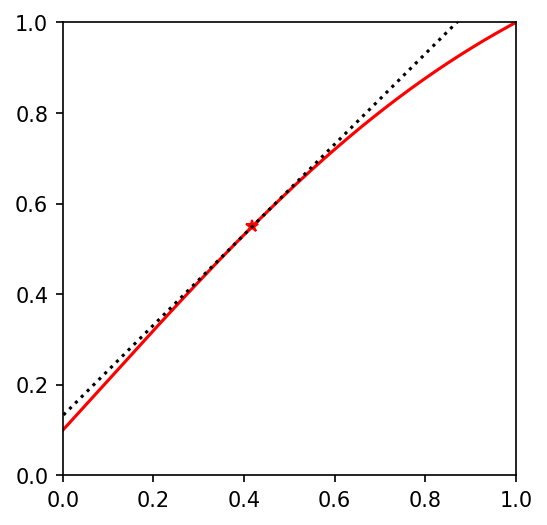

In [222]:
fig = plt.figure('logistic', dpi = 150)
x = np.linspace(0,1,1000)

def logistic0(k, spont, c50, x):
    e_kc50 = np.exp(k*c50)
    e_kc50_k = np.exp(k*(c50-1))
    a = (1-spont)*(1+e_kc50)*(1+e_kc50_k)/(e_kc50-e_kc50_k)
    b = 1 - a/(1+e_kc50_k)
    return a/(1+np.exp(-k*x)*e_kc50) + b

#NOTE: c50 is only a translational paramter in logistic function, the return value of logistic_c50 is the true c50
def logistic_c50(k,c50):
    x = 1+np.exp(k*c50)
    y = 1+np.exp(k*c50-k)
    A = 2*x*y/(x+y)-1
    return c50 - np.log(A)/k

def logistic_slope(k, spont, c50, x):
    e_kc50 = np.exp(k*c50)
    e_kc50_k = np.exp(k*(c50-1))
    a = (1-spont)*(1+e_kc50)*(1+e_kc50_k)/(e_kc50-e_kc50_k)
    return a*k*np.exp(-k*x)*e_kc50/np.power(1+np.exp(-k*x)*e_kc50,2)

intercept = 0.1
translation = 0.1
k = 2

y = logistic0(k, intercept, translation, x)
ax = fig.add_subplot(111)
ax.plot(x, y,'r')
c50 = logistic_c50(k,translation)
y_c50 = (intercept+1)/2
slope = logistic_slope(k,intercept,translation,c50)
print(f'c50 = {c50:.3f}, slope = {slope:.3f}')
ax.plot(c50, y_c50,'*r')

ax.plot([c50-1, c50, c50+1], [y_c50-slope,y_c50,y_c50+slope],':k')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')

In [14]:
def cone_isolating(l,m,s,n,wp):
    fig = plt.figure('logistic', dpi = 100)
    ax = fig.add_subplot(111)
    l = np.reshape(l,(n,1))
    m = np.reshape(m,(n,1))
    s = np.reshape(s,(n,1))
    lms = np.concatenate([l,m,s],1)
    rgb = np.matmul(LMS2sRGB,lms.T)
    x = np.arange(n)
    ax.plot(x,rgb[0,:],'r')
    ax.plot(x,rgb[1,:],'g')
    ax.plot(x,rgb[2,:],'b')
    onRecord = False
    recordOn = False
    offRecord = False
    for i in range(n):
        color = rgb[:,i].astype('float').T/255
        if sum(color>=0) == 3 and sum(color<=1) == 3:
            if not offRecord:
                Off = color
                offRecord = True
            ax.plot(x[i], np.sum(luminance(color)*255),'.', c=color)
            onColor = color
        else:
            if offRecord and not onRecord:
                recordOn = True
                onRecord = True
        
        if recordOn or i == n-1:
            On = onColor
            recordOn = False
    #ax.plot(l[:-1],np.diff(rgb[2,:]),':b')
    #ax.plot(l[:-1],np.diff(rgb[1,:]),':g')
    ax.plot(np.zeros(255)+wp,np.arange(255),':r')
    ax.plot(x,np.zeros(x.size),':k')
    ax.plot(x,np.zeros(x.size)+255,':k')
    print(f'{luminance(On)}, {luminance(Off)}')
    if onRecord and offRecord:
        return On, Off
    else:
        raise Exception('no positive values')

In [15]:
def luminance(rgb):
    return np.matmul(sRGB2XYZ[1,:],rgb.reshape((3,1)))

[[ 3.2406227  -1.5371978  -0.49868131]
 [-0.96893048  1.87575521  0.04152191]
 [ 0.05571601 -0.20404262  1.05710768]]
[ 0.37180824  0.35005428  0.28524582]
white point = [ 1.          0.94149144  0.76718532]


In [38]:
## white point from Reid and Shapley 2002
#x = 0.33
#y = 0.35

x = 0.3127
y = 0.3290
z = 1-x-y
XYZ2sRGB = np.linalg.inv(sRGB2XYZ)
print(f'{XYZ2sRGB}')
rgb_in_Y = np.matmul(XYZ2sRGB, np.array([x,y,z]).T)
print(f'{rgb_in_Y}')
Y = 1
wp = rgb_in_Y*Y/y
wp = wp/max(wp)
print(f'white point = {wp}')

[[ 3.2406227  -1.5371978  -0.49868131]
 [-0.96893048  1.87575521  0.04152191]
 [ 0.05571601 -0.20404262  1.05710768]]
[ 0.32892713  0.3290162   0.32905406]
white point = [ 0.99961427  0.99988497  1.        ]


In [55]:
cd = 100/255
lum = luminance(wp*cd)
print(f'luminance = {lum}')
RGB_wp = wp*cd
LMS_wp = np.matmul(sRGB2LMS, RGB_wp)
print(f'white point in LMS = {LMS_wp}')

luminance = [ 0.39209244]
white point in LMS = [ 0.39208326  0.39208529  0.39208179]


[ 0.43178272], [ 0.36662094]
0.2190476190476191: [  2.19047619e-01   7.07896377e-17   1.41580541e-16]
0.17968357791452697: [  1.79683578e-01   6.74874945e-05   1.91445768e-04], 


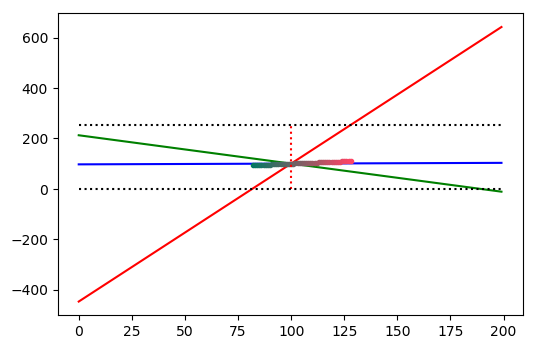

In [61]:
n = 200
l = np.reshape(np.arange(n),(n,1))
m = np.zeros(n) + LMS_wp[1]*255
s = np.zeros(n) + LMS_wp[2]*255
LOn, LOff = cone_isolating(l,m,s,n, LMS_wp[0]*255)
lms_LOn = np.matmul(sRGB2LMS, LOn.T)
lms_LOff = np.matmul(sRGB2LMS, LOff.T)
midpoint_con_rgb = np.abs(lms_LOn - lms_LOff)/(lms_LOn + lms_LOff)
wp_con_rgb = np.min(np.vstack((np.abs(lms_LOn - RGB_wp)/RGB_wp, np.abs(RGB_wp-lms_LOff)/RGB_wp)),0)
print(f'{midpoint_con_rgb[0]}: {midpoint_con_rgb}')
print(f'{wp_con_rgb[0]}: {wp_con_rgb}')

In [52]:
np.vstack((np.abs(LOn - wp)/wp, np.abs(wp-LOff)/wp))

array([[ 0.00630604,  0.73143764,  0.60455444],
       [ 0.9938836 ,  0.52852553,  0.60995368]])

[ 0.44474557], [ 0.30946937]
0.2872340425531915: [  1.41580007e-16   2.87234043e-01   7.07902703e-17]
0.210139203927158: [  1.98130781e-04   2.10139204e-01   1.91445768e-04], 


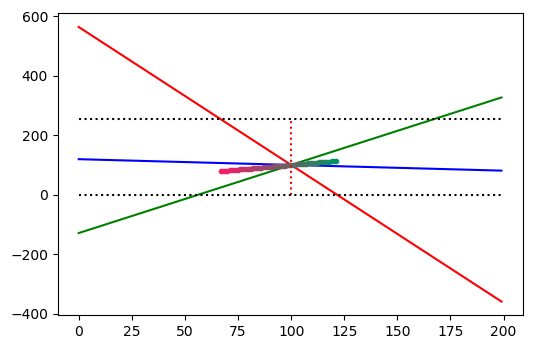

In [63]:
n = 200
m = np.reshape(np.arange(n),(n,1))
l = np.zeros((n,1)) + LMS_wp[0]*255
s = np.zeros((n,1)) + LMS_wp[2]*255
MOn, MOff = cone_isolating(l,m,s,n, LMS_wp[1]*255)
lms_LOn = np.matmul(sRGB2LMS, MOn.T)
lms_LOff = np.matmul(sRGB2LMS, MOff.T)
midpoint_con_rgb = np.abs(lms_LOn - lms_LOff)/(lms_LOn + lms_LOff)
wp_con_rgb = np.min(np.vstack((np.abs(lms_LOn - RGB_wp)/RGB_wp, np.abs(RGB_wp-lms_LOff)/RGB_wp)),0)
print(f'{midpoint_con_rgb[1]}: {midpoint_con_rgb}')
print(f'{wp_con_rgb[1]}: {wp_con_rgb}')

[ 0.39208872], [ 0.39209482]
0.8790322580645161: [  7.07900035e-17   7.07896377e-17   8.79032258e-01]
0.85: [  1.98130781e-04   6.74874945e-05   8.50000000e-01]


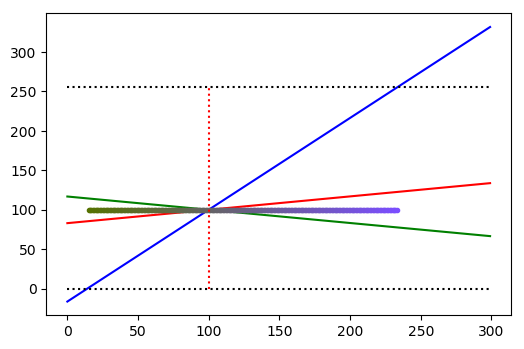

In [65]:
n = 300
s = np.reshape(np.arange(n),(n,1))
l = np.zeros((n,1)) + LMS_wp[0]*255
m = np.zeros((n,1)) + LMS_wp[1]*255
SOn, SOff = cone_isolating(l,m,s,n,LMS_wp[2]*255)
lms_LOn = np.matmul(sRGB2LMS, SOn.T)
lms_LOff = np.matmul(sRGB2LMS, SOff.T)
midpoint_con_rgb = np.abs(lms_LOn - lms_LOff)/(lms_LOn + lms_LOff)
wp_con_rgb = np.min(np.vstack((np.abs(lms_LOn - RGB_wp)/RGB_wp, np.abs(RGB_wp-lms_LOff)/RGB_wp)),0)
print(f'{midpoint_con_rgb[2]}: {midpoint_con_rgb}')
print(f'{wp_con_rgb[2]}: {wp_con_rgb}')

[ 1.          0.94149144  0.76718532],[ 0.99961427  0.99988497  1.        ]


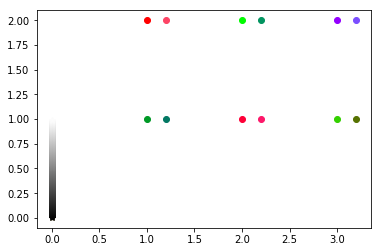

In [68]:
# white point in Reid and Shapley 2002
x = 0.33
y = 0.35
Y = 1
X = Y/y*x
Z = Y/y*(1-x-y)
XYZ = np.array([X,Y,Z])
XYZ2sRGB = np.linalg.inv(sRGB2XYZ)
color = np.matmul(XYZ2sRGB, XYZ.T)

fig = plt.figure('xyY')
ax = fig.add_subplot(111)
ax.plot(0,0, '*', c=color/max(color))
ax.plot(0.2,0, '*', c=wp)
for i in range(100):
    testcolor = np.matmul(LMS2sRGB, np.array([i/100,i/100,i/100]).T)
    ax.plot(0,i/100, '*', c=testcolor)

print(f'{color/max(color)},{wp}')

# Conway 2001
ax.plot(1,2, 'o', c=np.array([255, 0, 0])/256)
ax.plot(1,1, 'o', c=np.array([0, 154, 38])/256)

ax.plot(2,2, 'o', c=np.array([0, 252, 0])/256)
ax.plot(2,1, 'o', c=np.array([255, 0, 55])/256)

ax.plot(3,2, 'o', c=np.array([148, 0, 255])/256)
ax.plot(3,1, 'o', c=np.array([52, 209, 0])/256)

# model
ax.plot(1.2,2, 'o', c=LOn)
ax.plot(1.2,1, 'o', c=LOff)

ax.plot(2.2,2, 'o', c=MOn)
ax.plot(2.2,1, 'o', c=MOff)

ax.plot(3.2,2, 'o', c=SOn)
ax.plot(3.2,1, 'o', c=SOff)

In [328]:
sum(MOn), sum(MOff)

(1.2287486810998467, 1.7719181875105354)

In [329]:
RGB2XYZ

array([[ 2.76883088,  1.75170933,  1.13013505],
       [ 1.        ,  4.59060858,  0.06006668],
       [ 0.        ,  0.05650675,  5.5941685 ]])

In [330]:
from ext_signal import *

BGR2LMS = [[ 0.04166049  3.84105019  1.76802108]
 [ 0.07099193  5.03258835  0.54709498]
 [ 5.5941685   0.05650675  0.        ]]


In [331]:
img_to_LMS('bVHea.png')

In [31]:
def one_unknown_second_order_equation_solver(a,b,c):
    delta = b**2-4*a*c
    if delta == 0:
        return np.array([-b/2/a])
    else:
        if delta < 0:
            sqrt_delta = 1j*np.sqrt(-delta)
        else:
            sqrt_delta = np.sqrt(delta)
    return np.array([(-b-sqrt_delta)/2/a, (-b+sqrt_delta)/2/a])

def var_triag_dist(a,b,c): 
    return (a**2 + b**2 + c**2 - a*b - b*c -a*c)/18 

# guess and fix
def GAF_triag_dist(a0, b0, m, sd0):
    c0 = 3*m-a0-b0
    var = var_triag_dist(a0, b0, c0)
    p1 = 1
    p2 = -(a0+b0)
    p3 = a0*b0-6*(sd0**2-var)
    b = one_unknown_second_order_equation_solver(p1,p2,p3)[1]
    a = a0+b0-b
    c = c0
    return a, c, b

In [29]:
m = 63.68
sd0 = 33.06
a0 = 19.41
b0 = 128.10
a, c, b = GAF_triag_dist(a0, b0, m, sd0)
print(a, c, b)

-5.32258674239 43.53 152.832586742


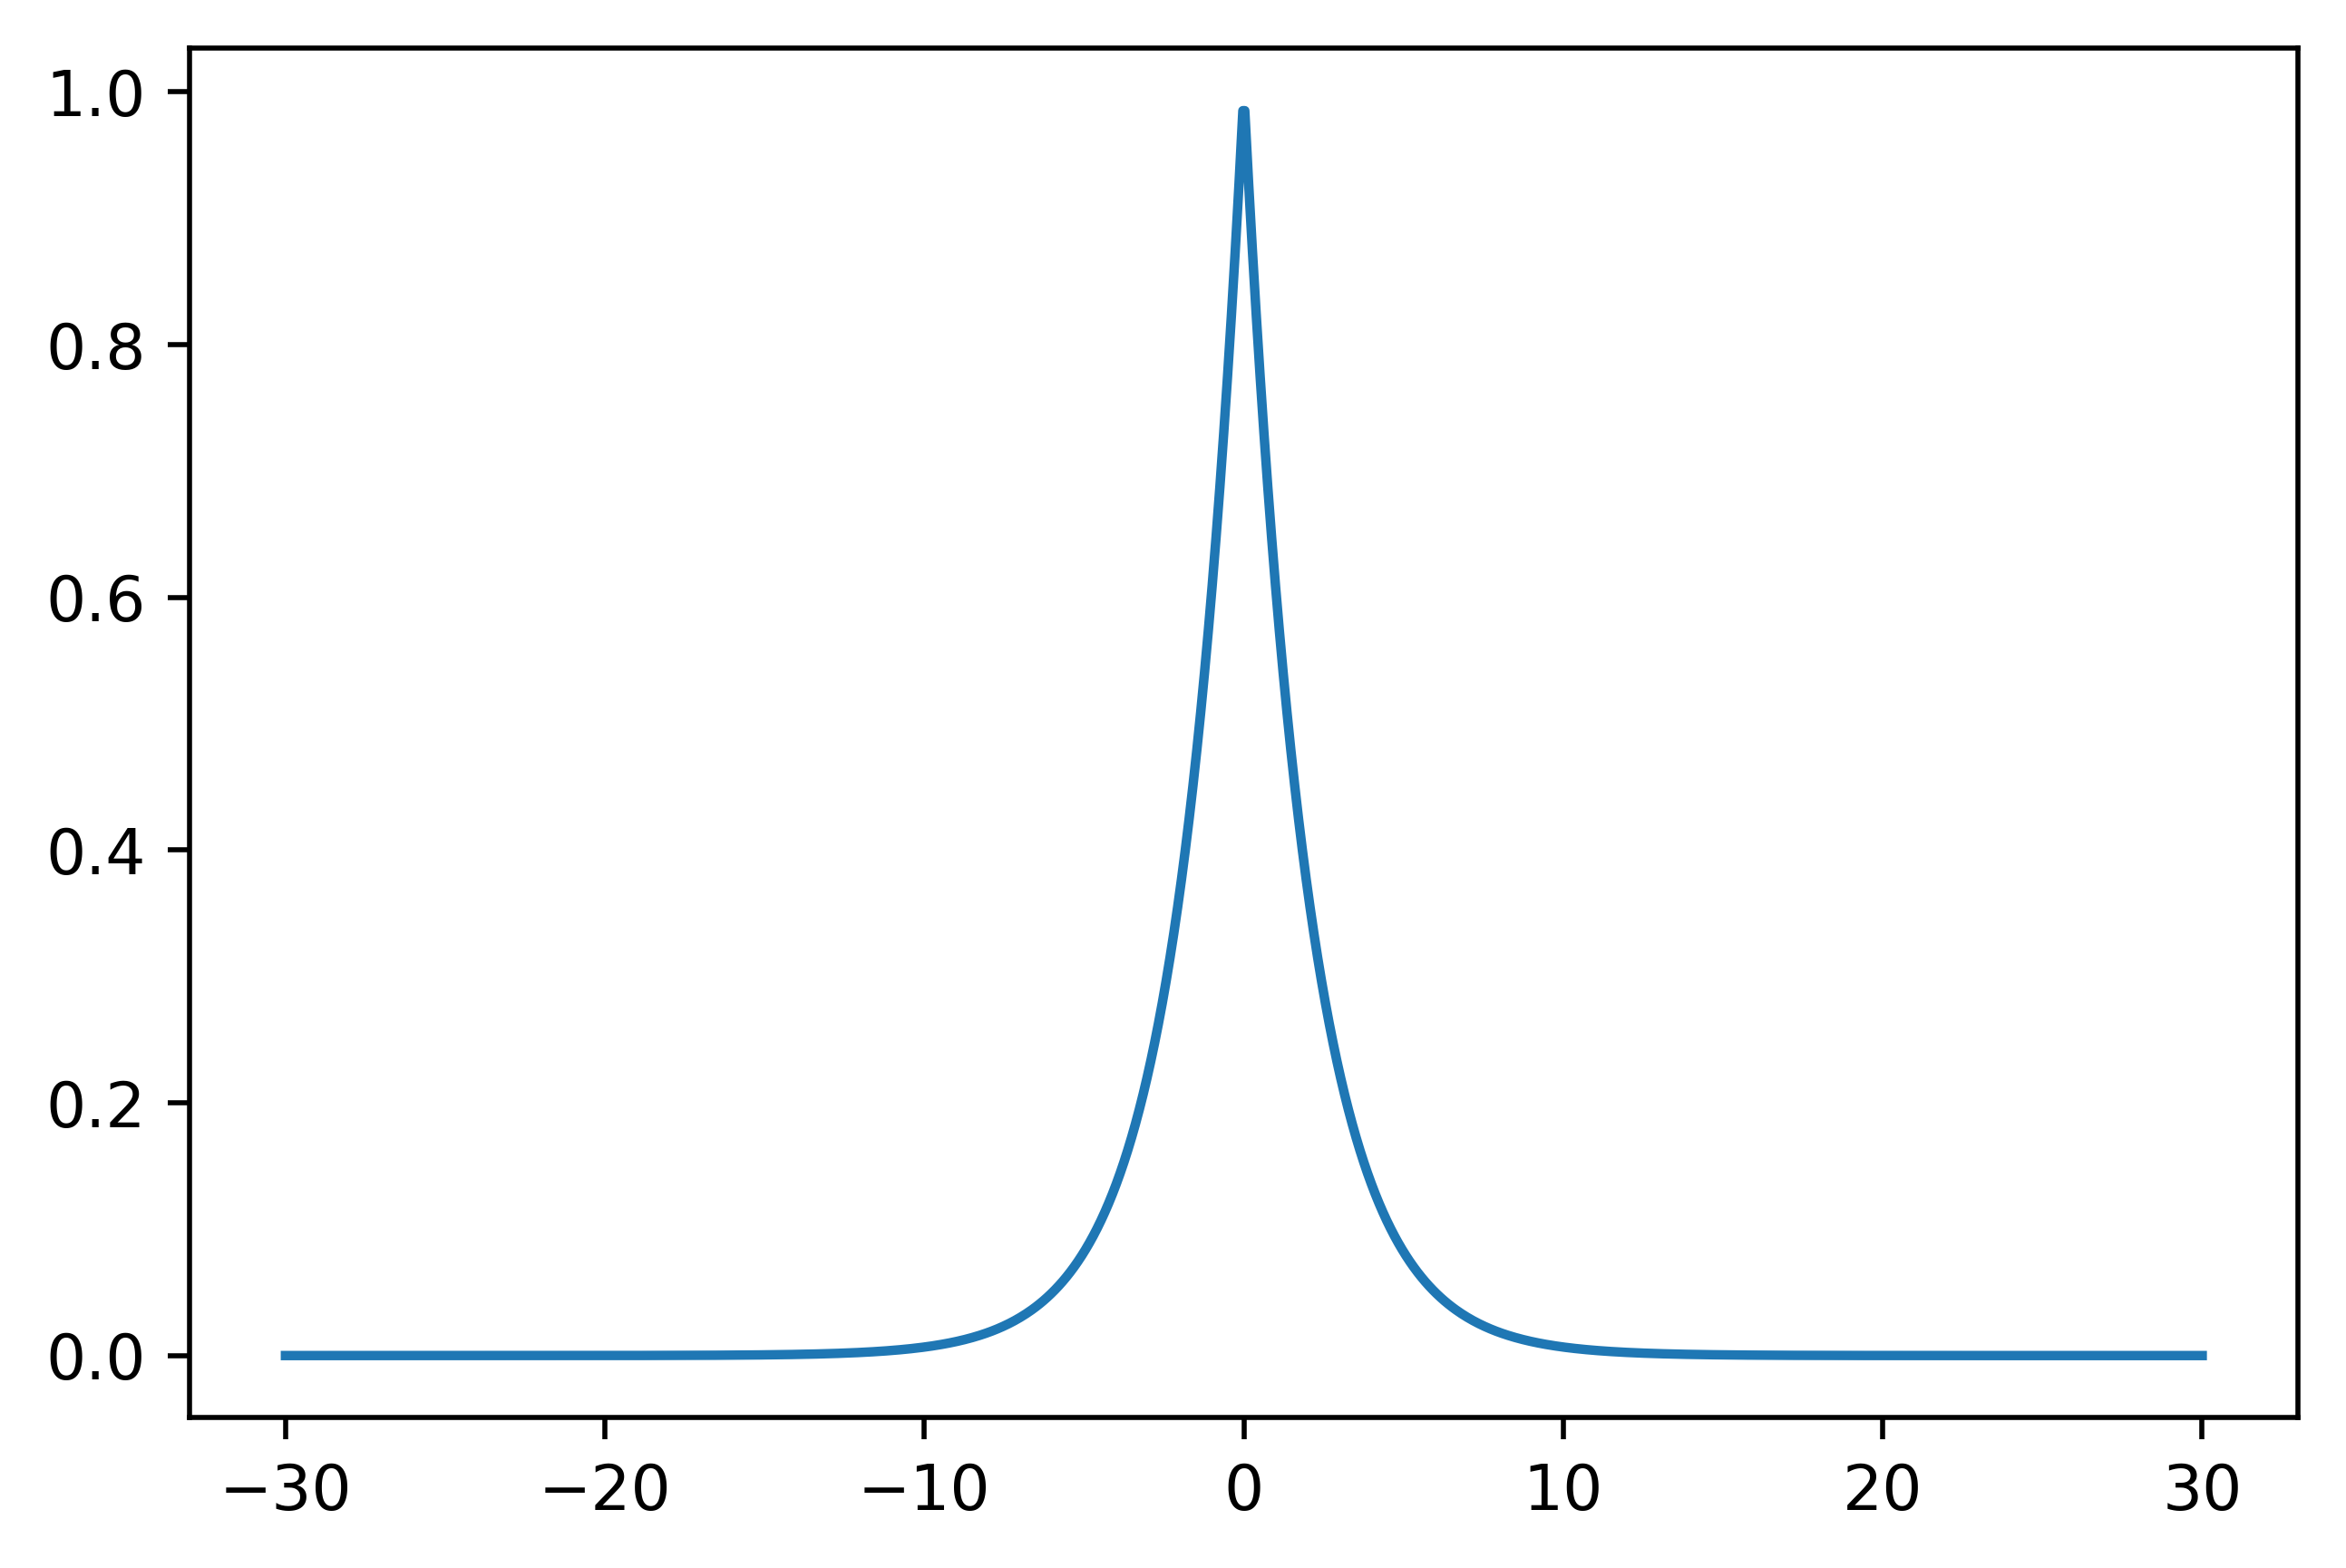

In [22]:
fig = plt.figure('gauss', dpi=500)
ax = fig.add_subplot(111)
mu = 0
left_std = 2
right_std = 4
x = np.linspace(-30,30,1000) - mu
y = np.copy(x)
#y[x>0] = y[x>0]/right_std
#y[x<0] = y[x<0]/left_std
y = np.sqrt(np.abs(y))
ax.plot(x, np.exp(-np.power(y,2)/2))